## Backtest Strategy Playground

Notebook ini dipakai untuk mencoba berbagai strategy dari folder `src/strategy_backtest/strategies`.
Ganti nilai `STRATEGY_NAME` pada sel konfigurasi untuk memanggil file strategy yang berbeda.

In [1]:
from __future__ import annotations

import io
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import get_ipython
from IPython.display import Image, display
from qf_lib.analysis.timeseries_analysis.timeseries_analysis import TimeseriesAnalysis
from qf_lib.common.enums.frequency import Frequency
from qf_lib.containers.series.simple_returns_series import SimpleReturnsSeries

PROJECT_ROOT = Path('..').resolve()
for path in (PROJECT_ROOT, PROJECT_ROOT / 'src'):
    if str(path) not in sys.path:
        sys.path.append(str(path))

_ip = get_ipython()
if _ip is not None:
    try:
        _ip.run_line_magic('matplotlib', 'inline')
    except AttributeError:
        plt.switch_backend('Agg')
else:
    plt.switch_backend('Agg')

warnings.filterwarnings('ignore', category=FutureWarning, module='qf_lib')

plt.style.use('seaborn-v0_8-darkgrid')

from src.strategy_backtest import (
    SignalBacktester,
    get_strategy,
    list_strategies,
    load_strategy_csv,
)


In [2]:
# Konfigurasi dataset & strategy
DATA_FILE = PROJECT_ROOT / 'data' / 'OKX_ETHUSDT.P, 1D.csv'
TIME_COLUMN = 'time'
PRICE_COLUMN = 'close'
ASSET_SYMBOL = 'ETHUSDT'

# Ganti nama strategy sesuai file di `src/strategy_backtest/strategies/`
STRATEGY_NAME = 'vwap'
# Opsional: override parameter default strategy
STRATEGY_PARAMS = {}

In [3]:
data, column_mapping = load_strategy_csv(DATA_FILE, time_column=TIME_COLUMN)
print(f'Dataset berisi {len(data):,} bar dengan {len(data.columns)} kolom.')
print('Contoh mapping kolom (sanitised -> original):')
for alias, original in list(column_mapping.items())[:10]:
    print(f'  {alias} -> {original}')

display(data.head())

Dataset berisi 2,152 bar dengan 35 kolom.
Contoh mapping kolom (sanitised -> original):
  time -> time
  open -> open
  high -> high
  low -> low
  close -> close
  volume -> Volume
  vwap -> VWAP
  vwap_1 -> VWAP.1
  ema -> EMA
  lucid_connector -> LUCID Connector


,open,high,low,close,volume,vwap,vwap_1,ema,lucid_connector,hyperwave,...,upper_confluence_zone,lower_confluence_zone,confluence_meter_value,custom_alert_condition_highlighter,alert_scripting_condition_highlighter,at_valuewhen,atr,histogram,macd,signal
time,,,,,,,,,,,,,,,,,,,,,
2019-12-25,127.64,127.72,123.40,125.07,2.193667e+06,125.396667,125.396667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,125.07,132.00,124.37,125.61,3.770336e+06,127.326667,127.326667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-27,125.66,126.96,122.65,126.26,5.765802e+06,125.290000,125.290000,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-28,126.24,129.68,125.86,128.09,6.235318e+06,127.876667,127.876667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-29,128.08,137.97,127.57,134.26,6.826287e+06,133.266667,133.266667,NaN,0,NaN,...,105,-5,28.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
available = list_strategies()
print('Strategi tersedia:', ', '.join(available))
strategy = get_strategy(STRATEGY_NAME, **STRATEGY_PARAMS)
print('Deskripsi strategi:')
print(f"- Nama: {strategy.metadata.name}")
print(f"- Deskripsi: {strategy.metadata.description}")
print(f"- Entry: {strategy.metadata.entry}")
print(f"- Exit: {strategy.metadata.exit}")
print('Parameter default:')
for key, value in strategy.metadata.parameters.items():
    print(f'  {key}: {value}')
if not strategy.metadata.parameters:
    print('  (tidak ada parameter default eksplisit)')
print('Parameter aktif:')
for key, value in strategy.params.items():
    print(f'  {key}: {value}')
if not strategy.params:
    print('  (menggunakan nilai default)')

signals = strategy.generate_signals(data)
print('Kolom sinyal:', list(signals.columns))
display(signals.head())

Strategi tersedia: ema112_atr, vwap
Deskripsi strategi:
- Nama: vwap
- Deskripsi: Strategi VWAP mean reversion: beli ketika harga di bawah VWAP dengan RSI bullish, jual ketika harga di atas VWAP dengan RSI bearish.
- Entry: Long: harga penutupan di bawah VWAP, RSI di atas level oversold, dan RSI menembus ke atas level 50. Short: harga penutupan di atas VWAP, RSI di bawah level overbought, dan RSI menembus ke bawah level 50.
- Exit: Stop loss berbasis ATR: posisi long keluar jika harga menyentuh entry - ATR*multiplier, posisi short keluar jika harga menyentuh entry + ATR*multiplier. Tidak ada target profit eksplisit.
Parameter default:
  rsi_length: 14
  rsi_overbought: 70
  rsi_oversold: 30
  atr_length: 14
  atr_stop_multiplier: 1.5
  session_frequency: 1D
Parameter aktif:
  rsi_length: 14
  rsi_overbought: 70
  rsi_oversold: 30
  atr_length: 14
  atr_stop_multiplier: 1.5
  session_frequency: 1D
Kolom sinyal: ['long_entry', 'long_exit', 'short_entry', 'short_exit', 'vwap', 'rsi', 'atr

,long_entry,long_exit,short_entry,short_exit,vwap,rsi,atr,active_entry_price,stop_level,position
time,,,,,,,,,,
2019-12-25,False,False,False,False,125.396667,NaN,4.320000,NaN,NaN,flat
2019-12-26,False,False,False,False,127.326667,NaN,4.556429,NaN,NaN,flat
2019-12-27,False,False,False,False,125.290000,NaN,4.538827,NaN,NaN,flat
2019-12-28,False,False,False,False,127.876667,NaN,4.487482,NaN,NaN,flat
2019-12-29,False,False,False,False,133.266667,NaN,4.909805,NaN,NaN,flat


In [5]:
backtester = SignalBacktester(data=data, price_column=PRICE_COLUMN)
outputs = backtester.run(signals)

metrics_series = pd.Series(outputs.metrics, name='value')
trade_summary_series = pd.Series(outputs.trade_summary, name='value')

trade_summary_order = [
    'total_trades', 'long_trades', 'short_trades',
    'winning_trades', 'losing_trades', 'breakeven_trades',
    'win_rate', 'loss_rate', 'breakeven_rate',
    'avg_pnl_pct', 'avg_pnl_currency', 'median_pnl_pct',
    'net_profit_pct', 'net_profit_currency',
    'gross_profit_pct', 'gross_loss_pct', 'profit_factor_pct',
    'gross_profit_currency', 'gross_loss_currency', 'profit_factor_currency',
    'avg_win_pct', 'avg_loss_pct', 'avg_win_currency', 'avg_loss_currency',
    'avg_bars', 'median_bars', 'avg_bars_winning', 'avg_bars_losing',
    'max_consecutive_wins', 'max_consecutive_losses',
    'time_in_market_pct', 'long_exposure_pct', 'short_exposure_pct',
    'avg_position', 'avg_abs_position',
    'best_trade_pct', 'worst_trade_pct', 'best_trade_currency', 'worst_trade_currency',
]
ordered_keys = [key for key in trade_summary_order if key in trade_summary_series.index]
remaining_keys = [key for key in trade_summary_series.index if key not in ordered_keys]
ordered_trade_summary = trade_summary_series.loc[ordered_keys + remaining_keys]

print('Metrik performa:')
display(metrics_series.to_frame().style.format({'value': '{:.4f}'}))

print('Ringkasan trade:')
display(ordered_trade_summary.to_frame().style.format({'value': '{:.4f}'}))

summary_lines = []
total_trades = trade_summary_series.get('total_trades')
if pd.notna(total_trades):
    summary_lines.append(f"Total trade dieksekusi: {int(total_trades)}")

winning_trades = trade_summary_series.get('winning_trades')
win_rate = trade_summary_series.get('win_rate')
if pd.notna(winning_trades) and pd.notna(win_rate):
    summary_lines.append(f"Menang: {int(winning_trades)} ({win_rate:.2%})")

losing_trades = trade_summary_series.get('losing_trades')
loss_rate = trade_summary_series.get('loss_rate')
if pd.notna(losing_trades) and pd.notna(loss_rate):
    summary_lines.append(f"Kalah: {int(losing_trades)} ({loss_rate:.2%})")

breakeven_trades = trade_summary_series.get('breakeven_trades')
breakeven_rate = trade_summary_series.get('breakeven_rate')
if pd.notna(breakeven_trades) and pd.notna(breakeven_rate):
    summary_lines.append(f"Break-even: {int(breakeven_trades)} ({breakeven_rate:.2%})")

net_profit_pct = trade_summary_series.get('net_profit_pct')
net_profit_currency = trade_summary_series.get('net_profit_currency')
if pd.notna(net_profit_pct):
    summary_lines.append(f"Akumulasi PnL %: {net_profit_pct:.2%}")
if pd.notna(net_profit_currency):
    summary_lines.append(f"Akumulasi PnL nominal: {net_profit_currency:,.2f}")

profit_factor_currency = trade_summary_series.get('profit_factor_currency')
if pd.notna(profit_factor_currency):
    summary_lines.append(f"Profit factor (nominal): {profit_factor_currency:.2f}")

profit_factor_pct = trade_summary_series.get('profit_factor_pct')
if pd.notna(profit_factor_pct):
    summary_lines.append(f"Profit factor (persentase): {profit_factor_pct:.2f}")

time_in_market = trade_summary_series.get('time_in_market_pct')
if pd.notna(time_in_market):
    summary_lines.append(f"Waktu terpapar pasar: {time_in_market:.2%}")

long_exposure = trade_summary_series.get('long_exposure_pct')
short_exposure = trade_summary_series.get('short_exposure_pct')
if pd.notna(long_exposure) and pd.notna(short_exposure):
    summary_lines.append(f"Proporsi bar long/short: {long_exposure:.2%} long / {short_exposure:.2%} short")

avg_bars = trade_summary_series.get('avg_bars')
if pd.notna(avg_bars):
    summary_lines.append(f"Rata-rata durasi trade: {avg_bars:.2f} bar")

avg_win_pct = trade_summary_series.get('avg_win_pct')
avg_loss_pct = trade_summary_series.get('avg_loss_pct')
if pd.notna(avg_win_pct) and pd.notna(avg_loss_pct):
    summary_lines.append(f"Rata-rata %PnL menang/kalah: {avg_win_pct:.2%} / {avg_loss_pct:.2%}")

max_win = trade_summary_series.get('best_trade_pct')
max_loss = trade_summary_series.get('worst_trade_pct')
if pd.notna(max_win) and pd.notna(max_loss):
    summary_lines.append(f"Trade terbaik/terburuk (%): {max_win:.2%} / {max_loss:.2%}")

if summary_lines:
    print('Ikhtisar singkat:')
    for line in summary_lines:
        print(f'  - {line}')

position_counts = outputs.positions.value_counts().rename('bars').sort_index()
if not position_counts.empty:
    position_summary = pd.DataFrame({'bars': position_counts})
    position_summary['percentage'] = position_summary['bars'] / len(outputs.positions)
    position_summary.index.name = 'position'
    print('Distribusi posisi berdasarkan jumlah bar:')
    display(position_summary.style.format({'bars': '{:,.0f}', 'percentage': '{:.2%}'}))

print(f'Log trade lengkap ({len(outputs.trades)} baris):')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(outputs.trades)

if not outputs.trades.empty:
    trade_columns = [
        'trade_id', 'direction', 'entry_time', 'exit_time', 'entry_price', 'exit_price',
        'pnl_pct', 'pnl_currency', 'bars_held', 'exit_reason',
    ]
    available_columns = [col for col in trade_columns if col in outputs.trades.columns]
    print('Top 5 trade terbaik berdasarkan % PnL:')
    display(outputs.trades.nlargest(5, 'pnl_pct')[available_columns])
    print('Top 5 trade terburuk berdasarkan % PnL:')
    display(outputs.trades.nsmallest(5, 'pnl_pct')[available_columns])


Metrik performa:


,value
total_return,7.3601
cagr,0.2823
sharpe_ratio,0.7775
annualised_vol,0.4494
max_drawdown,-0.5726
avg_drawdown_duration,43.8750


Ringkasan trade:


,value
total_trades,11.0000
long_trades,6.0000
short_trades,5.0000
winning_trades,3.0000
losing_trades,8.0000
breakeven_trades,0.0000
win_rate,0.2727
loss_rate,0.7273
breakeven_rate,0.0000
avg_pnl_pct,0.4097


Ikhtisar singkat:
  - Total trade dieksekusi: 11
  - Menang: 3 (27.27%)
  - Kalah: 8 (72.73%)
  - Break-even: 0 (0.00%)
  - Akumulasi PnL %: 450.66%
  - Akumulasi PnL nominal: 3,537.31
  - Profit factor (nominal): 2.32
  - Profit factor (persentase): 5.95
  - Waktu terpapar pasar: 49.58%
  - Proporsi bar long/short: 36.85% long / 12.73% short
  - Rata-rata durasi trade: 97.00 bar
  - Rata-rata %PnL menang/kalah: 180.59% / -11.39%
  - Trade terbaik/terburuk (%): 309.29% / -18.50%
Distribusi posisi berdasarkan jumlah bar:


,bars,percentage
position,,
-1.000000,274,12.73%
0.000000,"1,085",50.42%
1.000000,793,36.85%


Log trade lengkap (11 baris):


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason,entry_vwap,entry_rsi,entry_atr,entry_active_entry_price,entry_stop_level,entry_position,exit_vwap,exit_rsi,exit_atr,exit_active_entry_price,exit_stop_level,exit_position
0,1,Long,2020-10-31,2021-02-23,385.87,1579.33,3.092907,1193.46,115,long_exit_signal,386.590000,51.344910,18.807574,385.87,357.658638,long,1570.010000,44.537759,176.315882,1579.33,1843.803823,short
1,2,Short,2021-02-23,2021-03-09,1579.33,1871.55,-0.185028,-292.22,14,short_exit_signal,1570.010000,44.537759,176.315882,1579.33,1843.803823,short,1847.226667,62.711082,154.966602,NaN,NaN,flat
2,3,Short,2021-09-13,2021-09-18,3283.66,3435.57,-0.046262,-151.91,5,short_exit_signal,3273.893333,47.399827,258.340544,3283.66,3671.170816,short,3449.723333,51.013140,243.765346,3435.57,3069.921980,long
3,4,Long,2021-09-18,2021-09-20,3435.57,2978.97,-0.132904,-456.60,2,long_exit_signal,3449.723333,51.013140,243.765346,3435.57,3069.921980,long,3078.070000,38.917172,253.487467,NaN,NaN,flat
4,5,Short,2021-11-24,2022-07-15,4270.34,1231.35,0.711651,3038.99,233,short_exit_signal,4270.286667,48.695249,259.617937,4270.34,4659.766906,short,1234.073333,51.434431,100.284171,1231.35,1080.923744,long
5,6,Long,2022-07-15,2024-04-29,1231.35,3217.79,1.613221,1986.44,654,long_exit_signal,1234.073333,51.434431,100.284171,1231.35,1080.923744,long,3206.930000,48.589041,182.839801,3217.79,3492.049702,short
6,7,Short,2024-04-29,2024-05-20,3217.79,3662.68,-0.138259,-444.89,21,short_exit_signal,3206.930000,48.589041,182.839801,3217.79,3492.049702,short,3469.453333,70.151217,174.668192,NaN,NaN,flat
7,8,Long,2024-08-24,2024-08-27,2768.14,2457.60,-0.112184,-310.54,3,long_exit_signal,2772.933333,50.123936,148.833918,2768.14,2544.889122,long,2516.196667,35.926872,151.301479,NaN,NaN,flat
8,9,Short,2024-10-13,2024-10-14,2469.16,2630.19,-0.065217,-161.03,1,short_exit_signal,2463.753333,49.760007,97.668906,2469.16,2615.663358,short,2576.080000,60.894626,105.830412,NaN,NaN,flat
9,10,Long,2025-01-31,2025-02-02,3301.49,2869.54,-0.130835,-431.95,2,long_exit_signal,3317.580000,50.090859,189.102979,3301.49,3017.835532,long,2921.993333,35.286248,209.145374,NaN,NaN,flat


Top 5 trade terbaik berdasarkan % PnL:


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason
0,1,Long,2020-10-31,2021-02-23,385.87,1579.33,3.092907,1193.46,115,long_exit_signal
5,6,Long,2022-07-15,2024-04-29,1231.35,3217.79,1.613221,1986.44,654,long_exit_signal
4,5,Short,2021-11-24,2022-07-15,4270.34,1231.35,0.711651,3038.99,233,short_exit_signal
2,3,Short,2021-09-13,2021-09-18,3283.66,3435.57,-0.046262,-151.91,5,short_exit_signal
8,9,Short,2024-10-13,2024-10-14,2469.16,2630.19,-0.065217,-161.03,1,short_exit_signal


Top 5 trade terburuk berdasarkan % PnL:


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason
1,2,Short,2021-02-23,2021-03-09,1579.33,1871.55,-0.185028,-292.22,14,short_exit_signal
6,7,Short,2024-04-29,2024-05-20,3217.79,3662.68,-0.138259,-444.89,21,short_exit_signal
3,4,Long,2021-09-18,2021-09-20,3435.57,2978.97,-0.132904,-456.60,2,long_exit_signal
9,10,Long,2025-01-31,2025-02-02,3301.49,2869.54,-0.130835,-431.95,2,long_exit_signal
7,8,Long,2024-08-24,2024-08-27,2768.14,2457.60,-0.112184,-310.54,3,long_exit_signal


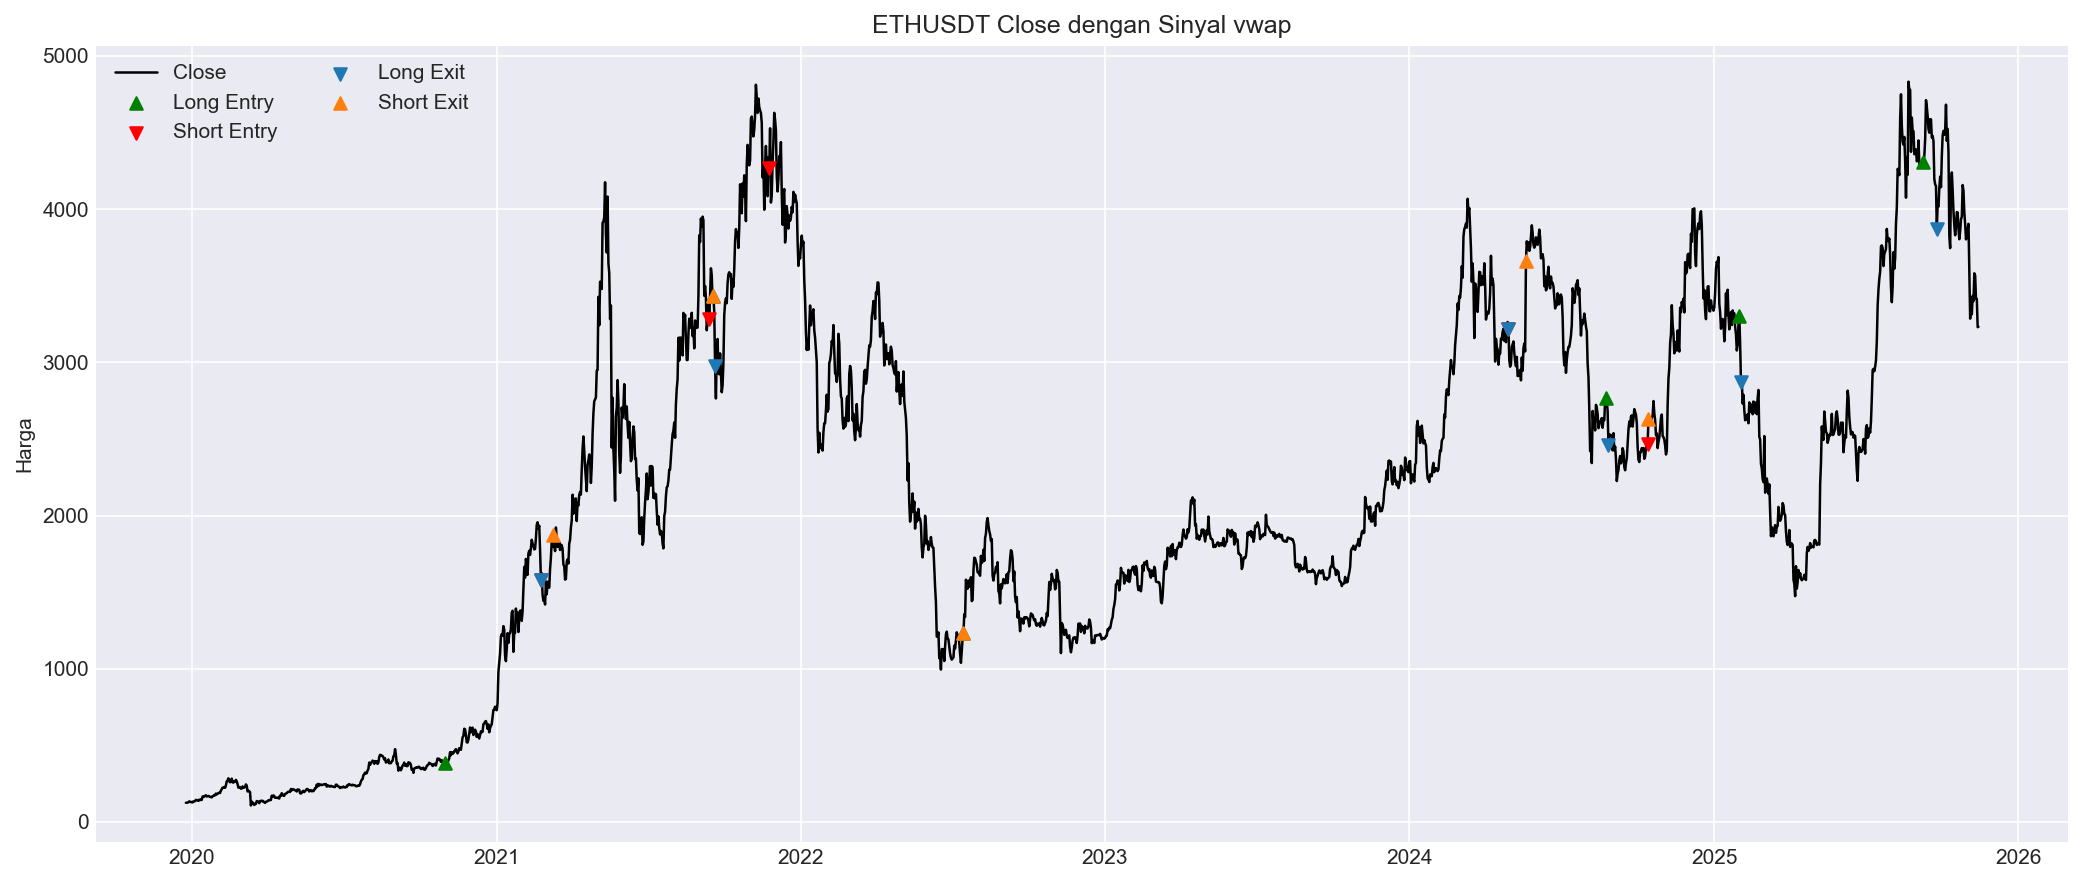

In [6]:
def _as_bool(series: pd.Series | None) -> pd.Series:
    if series is None:
        return pd.Series(False, index=data.index)
    aligned = series.reindex(data.index)
    return aligned.fillna(False).astype(bool)

close_prices = data[PRICE_COLUMN]
long_entries = _as_bool(signals.get('long_entry'))
long_exits = _as_bool(signals.get('long_exit'))
short_entries = _as_bool(signals.get('short_entry'))
short_exits = _as_bool(signals.get('short_exit'))

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(close_prices.index, close_prices, label='Close', color='black', linewidth=1.2)

if long_entries.any():
    ax.scatter(close_prices.index[long_entries], close_prices[long_entries], marker='^', color='green', label='Long Entry', zorder=5)
if short_entries.any():
    ax.scatter(close_prices.index[short_entries], close_prices[short_entries], marker='v', color='red', label='Short Entry', zorder=5)
if long_exits.any():
    ax.scatter(close_prices.index[long_exits], close_prices[long_exits], marker='v', color='tab:blue', label='Long Exit', zorder=6)
if short_exits.any():
    ax.scatter(close_prices.index[short_exits], close_prices[short_exits], marker='^', color='tab:orange', label='Short Exit', zorder=6)

ax.set_title(f'{ASSET_SYMBOL} Close dengan Sinyal {STRATEGY_NAME}')
ax.set_ylabel('Harga')
ax.legend(loc='upper left', ncol=2)
fig.tight_layout()

buffer = io.BytesIO()
fig.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
buffer.seek(0)
display(Image(data=buffer.read()))
plt.close(fig)


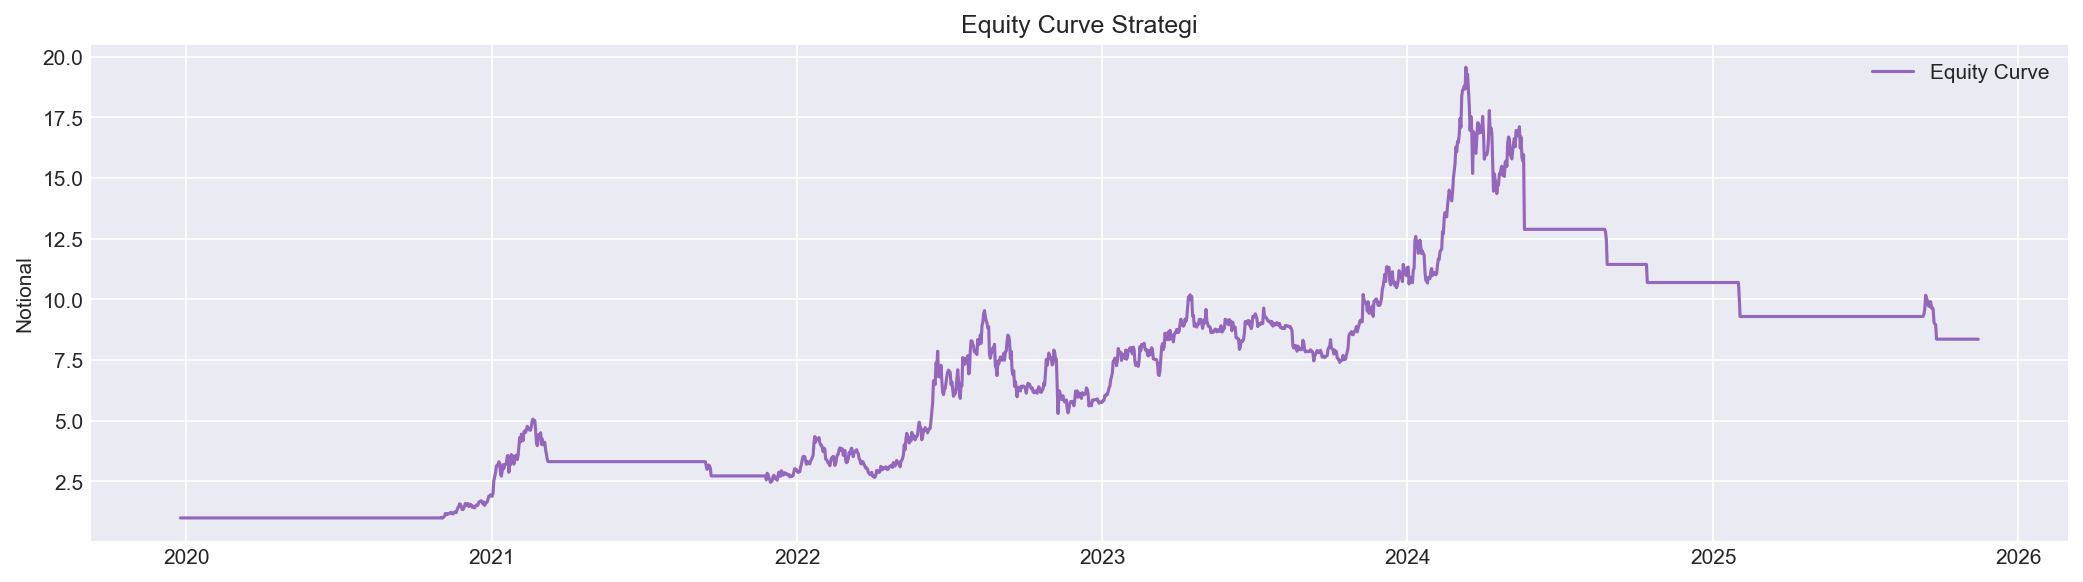

Metrik performa:


,value
total_return,7.3601
cagr,0.2823
sharpe_ratio,0.7775
annualised_vol,0.4494
max_drawdown,-0.5726
avg_drawdown_duration,43.8750


Ringkasan trade:


,value
total_trades,11.0000
long_trades,6.0000
short_trades,5.0000
winning_trades,3.0000
losing_trades,8.0000
breakeven_trades,0.0000
win_rate,0.2727
loss_rate,0.7273
breakeven_rate,0.0000
avg_pnl_pct,0.4097


Ikhtisar singkat:
  - Total trade dieksekusi: 11
  - Menang: 3 (27.27%)
  - Kalah: 8 (72.73%)
  - Break-even: 0 (0.00%)
  - Akumulasi PnL %: 450.66%
  - Akumulasi PnL nominal: 3,537.31
  - Profit factor (nominal): 2.32
  - Profit factor (persentase): 5.95
  - Waktu terpapar pasar: 49.58%
  - Proporsi bar long/short: 36.85% long / 12.73% short
  - Rata-rata durasi trade: 97.00 bar
  - Rata-rata %PnL menang/kalah: 180.59% / -11.39%
  - Trade terbaik/terburuk (%): 309.29% / -18.50%
Distribusi posisi berdasarkan jumlah bar:


,bars,percentage
position,,
-1.000000,274,12.73%
0.000000,"1,085",50.42%
1.000000,793,36.85%


Log trade lengkap (11 baris):


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason,entry_vwap,entry_rsi,entry_atr,entry_active_entry_price,entry_stop_level,entry_position,exit_vwap,exit_rsi,exit_atr,exit_active_entry_price,exit_stop_level,exit_position
0,1,Long,2020-10-31,2021-02-23,385.87,1579.33,3.092907,1193.46,115,long_exit_signal,386.590000,51.344910,18.807574,385.87,357.658638,long,1570.010000,44.537759,176.315882,1579.33,1843.803823,short
1,2,Short,2021-02-23,2021-03-09,1579.33,1871.55,-0.185028,-292.22,14,short_exit_signal,1570.010000,44.537759,176.315882,1579.33,1843.803823,short,1847.226667,62.711082,154.966602,NaN,NaN,flat
2,3,Short,2021-09-13,2021-09-18,3283.66,3435.57,-0.046262,-151.91,5,short_exit_signal,3273.893333,47.399827,258.340544,3283.66,3671.170816,short,3449.723333,51.013140,243.765346,3435.57,3069.921980,long
3,4,Long,2021-09-18,2021-09-20,3435.57,2978.97,-0.132904,-456.60,2,long_exit_signal,3449.723333,51.013140,243.765346,3435.57,3069.921980,long,3078.070000,38.917172,253.487467,NaN,NaN,flat
4,5,Short,2021-11-24,2022-07-15,4270.34,1231.35,0.711651,3038.99,233,short_exit_signal,4270.286667,48.695249,259.617937,4270.34,4659.766906,short,1234.073333,51.434431,100.284171,1231.35,1080.923744,long
5,6,Long,2022-07-15,2024-04-29,1231.35,3217.79,1.613221,1986.44,654,long_exit_signal,1234.073333,51.434431,100.284171,1231.35,1080.923744,long,3206.930000,48.589041,182.839801,3217.79,3492.049702,short
6,7,Short,2024-04-29,2024-05-20,3217.79,3662.68,-0.138259,-444.89,21,short_exit_signal,3206.930000,48.589041,182.839801,3217.79,3492.049702,short,3469.453333,70.151217,174.668192,NaN,NaN,flat
7,8,Long,2024-08-24,2024-08-27,2768.14,2457.60,-0.112184,-310.54,3,long_exit_signal,2772.933333,50.123936,148.833918,2768.14,2544.889122,long,2516.196667,35.926872,151.301479,NaN,NaN,flat
8,9,Short,2024-10-13,2024-10-14,2469.16,2630.19,-0.065217,-161.03,1,short_exit_signal,2463.753333,49.760007,97.668906,2469.16,2615.663358,short,2576.080000,60.894626,105.830412,NaN,NaN,flat
9,10,Long,2025-01-31,2025-02-02,3301.49,2869.54,-0.130835,-431.95,2,long_exit_signal,3317.580000,50.090859,189.102979,3301.49,3017.835532,long,2921.993333,35.286248,209.145374,NaN,NaN,flat


Top 5 trade terbaik berdasarkan % PnL:


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason
0,1,Long,2020-10-31,2021-02-23,385.87,1579.33,3.092907,1193.46,115,long_exit_signal
5,6,Long,2022-07-15,2024-04-29,1231.35,3217.79,1.613221,1986.44,654,long_exit_signal
4,5,Short,2021-11-24,2022-07-15,4270.34,1231.35,0.711651,3038.99,233,short_exit_signal
2,3,Short,2021-09-13,2021-09-18,3283.66,3435.57,-0.046262,-151.91,5,short_exit_signal
8,9,Short,2024-10-13,2024-10-14,2469.16,2630.19,-0.065217,-161.03,1,short_exit_signal


Top 5 trade terburuk berdasarkan % PnL:


,trade_id,direction,entry_time,exit_time,entry_price,exit_price,pnl_pct,pnl_currency,bars_held,exit_reason
1,2,Short,2021-02-23,2021-03-09,1579.33,1871.55,-0.185028,-292.22,14,short_exit_signal
6,7,Short,2024-04-29,2024-05-20,3217.79,3662.68,-0.138259,-444.89,21,short_exit_signal
3,4,Long,2021-09-18,2021-09-20,3435.57,2978.97,-0.132904,-456.60,2,long_exit_signal
9,10,Long,2025-01-31,2025-02-02,3301.49,2869.54,-0.130835,-431.95,2,long_exit_signal
7,8,Long,2024-08-24,2024-08-27,2768.14,2457.60,-0.112184,-310.54,3,long_exit_signal


In [7]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(outputs.results.index, outputs.results['equity_curve'], color='C4', label='Equity Curve')
ax.set_title('Equity Curve Strategi')
ax.set_ylabel('Notional')
ax.legend()
fig.tight_layout()

plot_buffer = io.BytesIO()
fig.savefig(plot_buffer, format='png', dpi=150, bbox_inches='tight')
plot_buffer.seek(0)
display(Image(data=plot_buffer.read()))
plt.close(fig)

trade_summary_order = [
    'total_trades', 'long_trades', 'short_trades',
    'winning_trades', 'losing_trades', 'breakeven_trades',
    'win_rate', 'loss_rate', 'breakeven_rate',
    'avg_pnl_pct', 'avg_pnl_currency', 'median_pnl_pct',
    'net_profit_pct', 'net_profit_currency',
    'gross_profit_pct', 'gross_loss_pct', 'profit_factor_pct',
    'gross_profit_currency', 'gross_loss_currency', 'profit_factor_currency',
    'avg_win_pct', 'avg_loss_pct', 'avg_win_currency', 'avg_loss_currency',
    'avg_bars', 'median_bars', 'avg_bars_winning', 'avg_bars_losing',
    'max_consecutive_wins', 'max_consecutive_losses',
    'time_in_market_pct', 'long_exposure_pct', 'short_exposure_pct',
    'avg_position', 'avg_abs_position',
    'best_trade_pct', 'worst_trade_pct', 'best_trade_currency', 'worst_trade_currency',
]
ordered_keys = [key for key in trade_summary_order if key in trade_summary_series.index]
remaining_keys = [key for key in trade_summary_series.index if key not in ordered_keys]
ordered_trade_summary = trade_summary_series.loc[ordered_keys + remaining_keys]

print('Metrik performa:')
display(metrics_series.to_frame().style.format({'value': '{:.4f}'}))

print('Ringkasan trade:')
display(ordered_trade_summary.to_frame().style.format({'value': '{:.4f}'}))

summary_lines = []
total_trades = trade_summary_series.get('total_trades')
if pd.notna(total_trades):
    summary_lines.append(f"Total trade dieksekusi: {int(total_trades)}")

winning_trades = trade_summary_series.get('winning_trades')
win_rate = trade_summary_series.get('win_rate')
if pd.notna(winning_trades) and pd.notna(win_rate):
    summary_lines.append(f"Menang: {int(winning_trades)} ({win_rate:.2%})")

losing_trades = trade_summary_series.get('losing_trades')
loss_rate = trade_summary_series.get('loss_rate')
if pd.notna(losing_trades) and pd.notna(loss_rate):
    summary_lines.append(f"Kalah: {int(losing_trades)} ({loss_rate:.2%})")

breakeven_trades = trade_summary_series.get('breakeven_trades')
breakeven_rate = trade_summary_series.get('breakeven_rate')
if pd.notna(breakeven_trades) and pd.notna(breakeven_rate):
    summary_lines.append(f"Break-even: {int(breakeven_trades)} ({breakeven_rate:.2%})")

net_profit_pct = trade_summary_series.get('net_profit_pct')
net_profit_currency = trade_summary_series.get('net_profit_currency')
if pd.notna(net_profit_pct):
    summary_lines.append(f"Akumulasi PnL %: {net_profit_pct:.2%}")
if pd.notna(net_profit_currency):
    summary_lines.append(f"Akumulasi PnL nominal: {net_profit_currency:,.2f}")

profit_factor_currency = trade_summary_series.get('profit_factor_currency')
if pd.notna(profit_factor_currency):
    summary_lines.append(f"Profit factor (nominal): {profit_factor_currency:.2f}")

profit_factor_pct = trade_summary_series.get('profit_factor_pct')
if pd.notna(profit_factor_pct):
    summary_lines.append(f"Profit factor (persentase): {profit_factor_pct:.2f}")

time_in_market = trade_summary_series.get('time_in_market_pct')
if pd.notna(time_in_market):
    summary_lines.append(f"Waktu terpapar pasar: {time_in_market:.2%}")

long_exposure = trade_summary_series.get('long_exposure_pct')
short_exposure = trade_summary_series.get('short_exposure_pct')
if pd.notna(long_exposure) and pd.notna(short_exposure):
    summary_lines.append(f"Proporsi bar long/short: {long_exposure:.2%} long / {short_exposure:.2%} short")

avg_bars = trade_summary_series.get('avg_bars')
if pd.notna(avg_bars):
    summary_lines.append(f"Rata-rata durasi trade: {avg_bars:.2f} bar")

avg_win_pct = trade_summary_series.get('avg_win_pct')
avg_loss_pct = trade_summary_series.get('avg_loss_pct')
if pd.notna(avg_win_pct) and pd.notna(avg_loss_pct):
    summary_lines.append(f"Rata-rata %PnL menang/kalah: {avg_win_pct:.2%} / {avg_loss_pct:.2%}")

max_win = trade_summary_series.get('best_trade_pct')
max_loss = trade_summary_series.get('worst_trade_pct')
if pd.notna(max_win) and pd.notna(max_loss):
    summary_lines.append(f"Trade terbaik/terburuk (%): {max_win:.2%} / {max_loss:.2%}")

if summary_lines:
    print('Ikhtisar singkat:')
    for line in summary_lines:
        print(f'  - {line}')

position_counts = outputs.positions.value_counts().rename('bars').sort_index()
if not position_counts.empty:
    position_summary = pd.DataFrame({'bars': position_counts})
    position_summary['percentage'] = position_summary['bars'] / len(outputs.positions)
    position_summary.index.name = 'position'
    print('Distribusi posisi berdasarkan jumlah bar:')
    display(position_summary.style.format({'bars': '{:,.0f}', 'percentage': '{:.2%}'}))

print(f'Log trade lengkap ({len(outputs.trades)} baris):')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(outputs.trades)

if not outputs.trades.empty:
    trade_columns = [
        'trade_id', 'direction', 'entry_time', 'exit_time', 'entry_price', 'exit_price',
        'pnl_pct', 'pnl_currency', 'bars_held', 'exit_reason',
    ]
    available_columns = [col for col in trade_columns if col in outputs.trades.columns]
    print('Top 5 trade terbaik berdasarkan % PnL:')
    display(outputs.trades.nlargest(5, 'pnl_pct')[available_columns])
    print('Top 5 trade terburuk berdasarkan % PnL:')
    display(outputs.trades.nsmallest(5, 'pnl_pct')[available_columns])


In [8]:
returns_series = outputs.results['strategy_return'].astype(float)
analysis = TimeseriesAnalysis(SimpleReturnsSeries(returns_series), Frequency.DAILY)

qflib_metrics = pd.Series({
    'total_return': analysis.total_return,
    'cagr': analysis.cagr,
    'sharpe_ratio': analysis.sharpe_ratio,
    'sortino_ratio': analysis.sorino_ratio,
    'omega_ratio': analysis.omega_ratio,
    'calmar_ratio': analysis.calmar_ratio,
    'gain_to_pain_ratio': analysis.gain_to_pain_ratio,
    'annualised_vol': analysis.annualised_vol,
    'annualised_downside_vol': analysis.annualised_downside_vol,
    'annualised_cvar': analysis.annualised_cvar,
    'max_drawdown': analysis.max_drawdown,
    'avg_drawdown_duration': analysis.avg_drawdown_duration,
}, name='value')

print('Metrik tambahan QF-Lib:')
display(qflib_metrics.to_frame().style.format({'value': '{:.4f}'}))

trade_distribution = outputs.trades[['pnl_pct', 'pnl_currency', 'bars_held']].describe().T
print('Statistik distribusi trade:')
display(trade_distribution)

direction_counts = outputs.trades['direction'].value_counts().rename('count').to_frame()
direction_counts['percentage'] = direction_counts['count'] / len(outputs.trades)
print('Distribusi posisi:')
display(direction_counts)

exit_reason_counts = outputs.trades['exit_reason'].value_counts().rename('count').to_frame()
exit_reason_counts['percentage'] = exit_reason_counts['count'] / len(outputs.trades)
print('Distribusi alasan keluar:')
display(exit_reason_counts)


Metrik tambahan QF-Lib:


,value
total_return,7.3601
cagr,0.4339
sharpe_ratio,0.8033
sortino_ratio,0.9229
omega_ratio,1.2242
calmar_ratio,0.7578
gain_to_pain_ratio,1.4689
annualised_vol,0.4487
annualised_downside_vol,0.4702
annualised_cvar,-0.6767


Statistik distribusi trade:


,count,mean,std,min,25%,50%,75%,max
pnl_pct,11.0,0.409695,1.046224,-0.185028,-0.131869,-0.100447,0.332694,3.092907
pnl_currency,11.0,321.573636,1203.290322,-456.600000,-432.195000,-292.220000,520.775000,3038.990000
bars_held,11.0,97.000000,198.166597,1.000000,2.500000,14.000000,68.000000,654.000000


Distribusi posisi:


,count,percentage
direction,,
Long,6,0.545455
Short,5,0.454545


Distribusi alasan keluar:


,count,percentage
exit_reason,,
long_exit_signal,6,0.545455
short_exit_signal,5,0.454545


In [9]:
def _trade_path_metrics(row: pd.Series) -> pd.Series:
    entry_time = row['entry_time']
    exit_time = row['exit_time']
    price_path = data.loc[entry_time:exit_time, PRICE_COLUMN].astype(float)
    if price_path.empty:
        return pd.Series({
            'mfe_pct': np.nan,
            'mae_pct': np.nan,
            'max_favourable_close': np.nan,
            'max_adverse_close': np.nan,
        })

    entry_price = float(row['entry_price'])
    if row['direction'] == 'Long':
        relative = price_path / entry_price - 1.0
    else:
        relative = entry_price / price_path - 1.0

    mfe_idx = relative.idxmax()
    mae_idx = relative.idxmin()
    return pd.Series({
        'mfe_pct': float(relative.max()),
        'mae_pct': float(relative.min()),
        'max_favourable_close': float(price_path.loc[mfe_idx]) if mfe_idx in price_path.index else np.nan,
        'max_adverse_close': float(price_path.loc[mae_idx]) if mae_idx in price_path.index else np.nan,
    })

loss_trades = outputs.trades.loc[outputs.trades['pnl_pct'] <= 0].copy()
loss_reason_counts = pd.DataFrame()
if not loss_trades.empty:
    path_metrics = loss_trades.apply(_trade_path_metrics, axis=1)
    loss_trades = pd.concat([loss_trades, path_metrics], axis=1)
    loss_trades['equity_at_entry'] = outputs.results.loc[loss_trades['entry_time'], 'equity_curve'].values
    loss_trades['equity_at_exit'] = outputs.results.loc[loss_trades['exit_time'], 'equity_curve'].values
    loss_trades['drawdown_at_exit'] = outputs.results.loc[loss_trades['exit_time'], 'drawdown'].values
    loss_trades['return_vs_vwap_entry'] = loss_trades['entry_price'] / loss_trades['entry_vwap'] - 1.0
    loss_trades['return_vs_vwap_exit'] = loss_trades['exit_price'] / loss_trades['exit_vwap'] - 1.0

    columns_to_show = [
        'trade_id', 'direction', 'entry_time', 'exit_time', 'exit_reason', 'bars_held',
        'entry_price', 'exit_price', 'pnl_pct', 'mfe_pct', 'mae_pct',
        'max_favourable_close', 'max_adverse_close', 'equity_at_entry', 'equity_at_exit',
        'drawdown_at_exit', 'entry_rsi', 'exit_rsi', 'entry_macd', 'exit_macd',
        'entry_atr', 'exit_atr', 'entry_volume_ma', 'exit_volume_ma',
        'entry_stop_level', 'exit_stop_level', 'entry_target_level', 'exit_target_level',
        'return_vs_vwap_entry', 'return_vs_vwap_exit',
    ]
    available_columns = [col for col in columns_to_show if col in loss_trades.columns]
    print(f'Detail {len(loss_trades)} trade loss:')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(loss_trades[available_columns])

    loss_reason_counts = loss_trades['exit_reason'].value_counts().rename('count').to_frame()
    loss_reason_counts['percentage'] = loss_reason_counts['count'] / len(loss_trades)
    print('Ringkasan alasan trade loss:')
    display(loss_reason_counts)
else:
    print('Tidak ada trade yang mengalami kerugian pada periode ini.')

export_frames: dict[str, pd.DataFrame] = {
    'results_subset': results_subset,
    'returns_summary': returns_summary,
    'monthly_returns': monthly_returns.to_frame('monthly_return'),
    'full_results': outputs.results,
    'qflib_metrics': qflib_metrics.to_frame(),
    'trade_distribution': trade_distribution,
    'direction_counts': direction_counts,
    'exit_reason_counts': exit_reason_counts,
}
if not loss_trades.empty:
    export_frames['loss_trades'] = loss_trades

export_filename = f"Optimize - {DATA_FILE.stem}.xlsx"
EXPORT_PATH = PROJECT_ROOT / 'outputs' / export_filename
EXPORT_PATH.parent.mkdir(parents=True, exist_ok=True)

if EXPORT_PATH.exists():
    EXPORT_PATH.unlink()

with pd.ExcelWriter(EXPORT_PATH, engine='openpyxl') as writer:
    for sheet_name, frame in export_frames.items():
        safe_name = sheet_name[:31]
        frame.to_excel(writer, sheet_name=safe_name)
print(f'Data berhasil diekspor ke: {EXPORT_PATH}')


Detail 8 trade loss:


,trade_id,direction,entry_time,exit_time,exit_reason,bars_held,entry_price,exit_price,pnl_pct,mfe_pct,mae_pct,max_favourable_close,max_adverse_close,equity_at_entry,equity_at_exit,drawdown_at_exit,entry_rsi,exit_rsi,entry_atr,exit_atr,entry_stop_level,exit_stop_level,return_vs_vwap_entry,return_vs_vwap_exit
1,2,Short,2021-02-23,2021-03-09,short_exit_signal,14,1579.33,1871.55,-0.185028,0.112753,-0.156138,1419.30,1871.55,4.092907,3.317791,-0.345432,44.537759,62.711082,176.315882,154.966602,1843.803823,NaN,0.005936,0.013167
2,3,Short,2021-09-13,2021-09-18,short_exit_signal,5,3283.66,3435.57,-0.046262,0.000000,-0.091375,3283.66,3613.88,3.317791,3.147885,-0.378953,47.399827,51.013140,258.340544,243.765346,3671.170816,3069.92198,0.002983,-0.004103
3,4,Long,2021-09-18,2021-09-20,long_exit_signal,2,3435.57,2978.97,-0.132904,0.000000,-0.132904,3435.57,2978.97,3.147885,2.729520,-0.461493,51.013140,38.917172,243.765346,253.487467,3069.921980,NaN,-0.004103,-0.032195
6,7,Short,2024-04-29,2024-05-20,short_exit_signal,21,3217.79,3662.68,-0.138259,0.116311,-0.121466,2882.52,3662.68,15.474545,12.883943,-0.341340,48.589041,70.151217,182.839801,174.668192,3492.049702,NaN,0.003386,0.055694
7,8,Long,2024-08-24,2024-08-27,long_exit_signal,3,2768.14,2457.60,-0.112184,0.000000,-0.112184,2768.14,2457.60,12.883943,11.438575,-0.415231,50.123936,35.926872,148.833918,151.301479,2544.889122,NaN,-0.001729,-0.023288
8,9,Short,2024-10-13,2024-10-14,short_exit_signal,1,2469.16,2630.19,-0.065217,0.000000,-0.061224,2469.16,2630.19,11.438575,10.692591,-0.453368,49.760007,60.894626,97.668906,105.830412,2615.663358,NaN,0.002194,0.021005
9,10,Long,2025-01-31,2025-02-02,long_exit_signal,2,3301.49,2869.54,-0.130835,0.000000,-0.130835,3301.49,2869.54,10.692591,9.293628,-0.524886,50.090859,35.286248,189.102979,209.145374,3017.835532,NaN,-0.004850,-0.017951
10,11,Long,2025-09-08,2025-09-25,long_exit_signal,17,4305.16,3872.72,-0.100447,0.094456,-0.100447,4711.81,3872.72,9.293628,8.360111,-0.572610,50.029172,30.541374,207.759118,188.088429,3993.521323,NaN,-0.003783,-0.019732


Ringkasan alasan trade loss:


,count,percentage
exit_reason,,
short_exit_signal,4,0.5
long_exit_signal,4,0.5


NameError: name 'results_subset' is not defined